In [67]:
import cv2
import rawpy
from glob import glob
import matplotlib.pyplot as plt

def plot_image(im):
    plt.figure(figsize = [30,40])
    plt.imshow(im)
    plt.show()

paths = glob("./First slot/*.CR2")
raw = rawpy.imread(paths[0]).postprocess()
plot_image(raw)

KeyboardInterrupt: 

<Figure size 2160x2880 with 0 Axes>

True


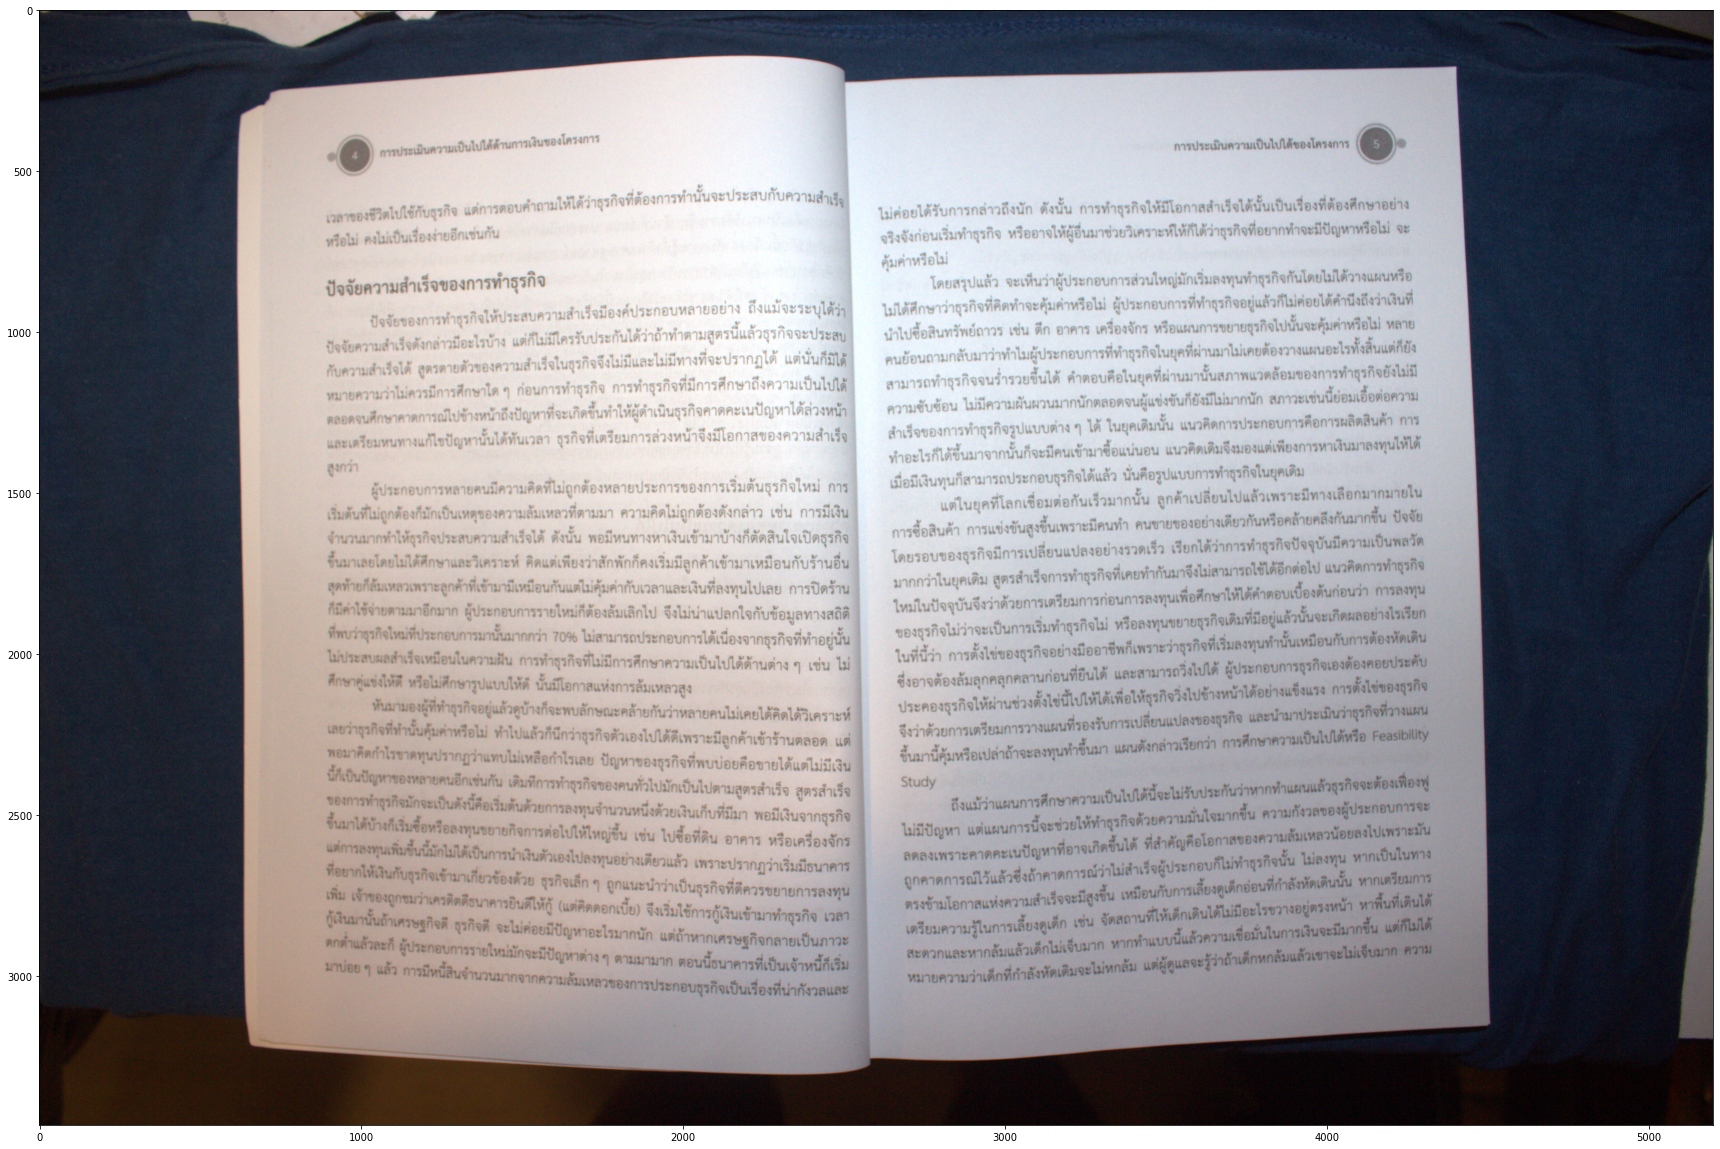

In [ ]:
raw = rawpy.imread(paths[7]).postprocess()
if raw.shape[0] >= raw.shape[1]: 
    raw = cv2.rotate(raw, cv2.ROTATE_90_COUNTERCLOCKWISE)
plot_image(raw)

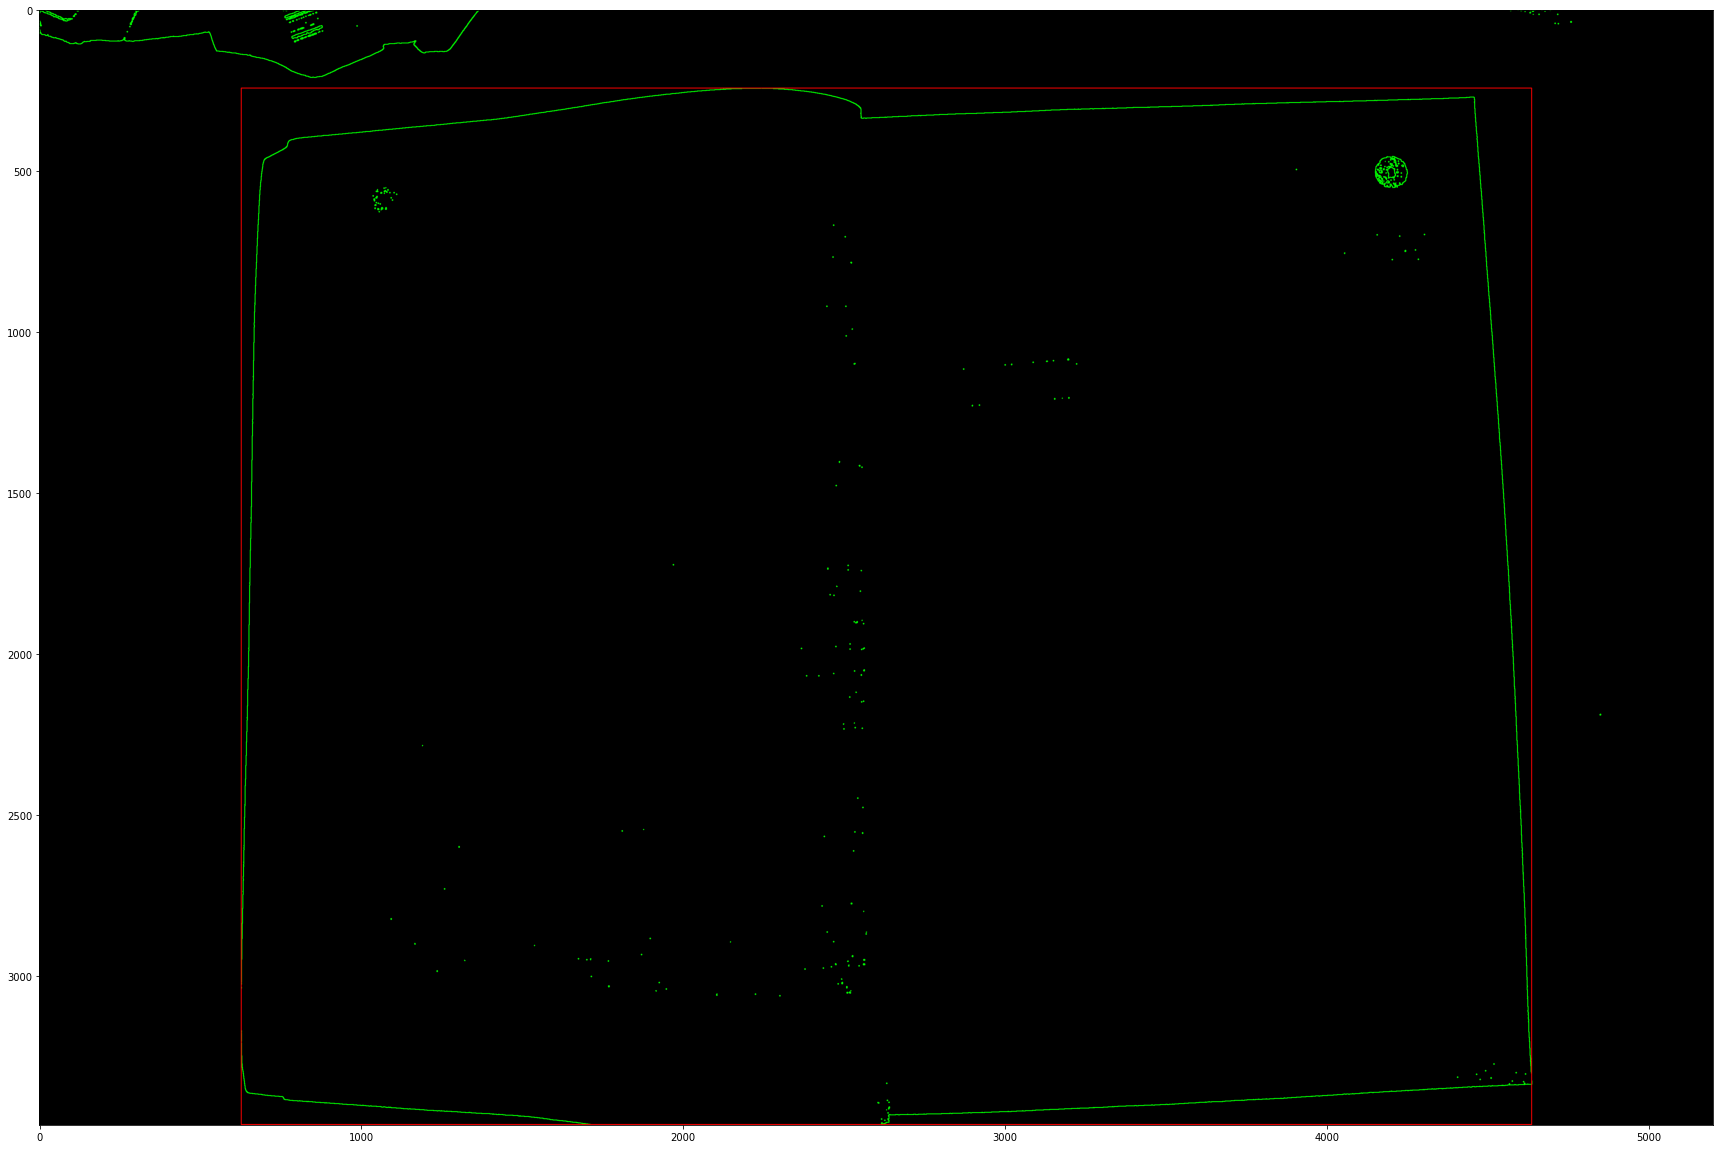

In [95]:
import numpy as np
closed_arclength = lambda x: cv2.arcLength(x, closed = True)
raw = rawpy.imread(paths[9]).postprocess()
blue = raw[:,:,0]
blur = cv2.threshold(cv2.GaussianBlur(blue, (5,5), 0), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
canny = cv2.Canny(blur[1], 20, 200)
canny = cv2.erode(cv2.dilate(canny, np.ones((3,3))), np.ones((3,3)))
contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
img = np.zeros(raw.shape)
ctr = max(contours, key = closed_arclength)
cv2.drawContours(img, contours, -1, (0,255,0), 2)
rect = cv2.minAreaRect(ctr)
box = np.int0(cv2.boxPoints(rect))
cv2.drawContours(img, [box], 0, (255, 0, 0), 2)
plot_image(img.astype(int))

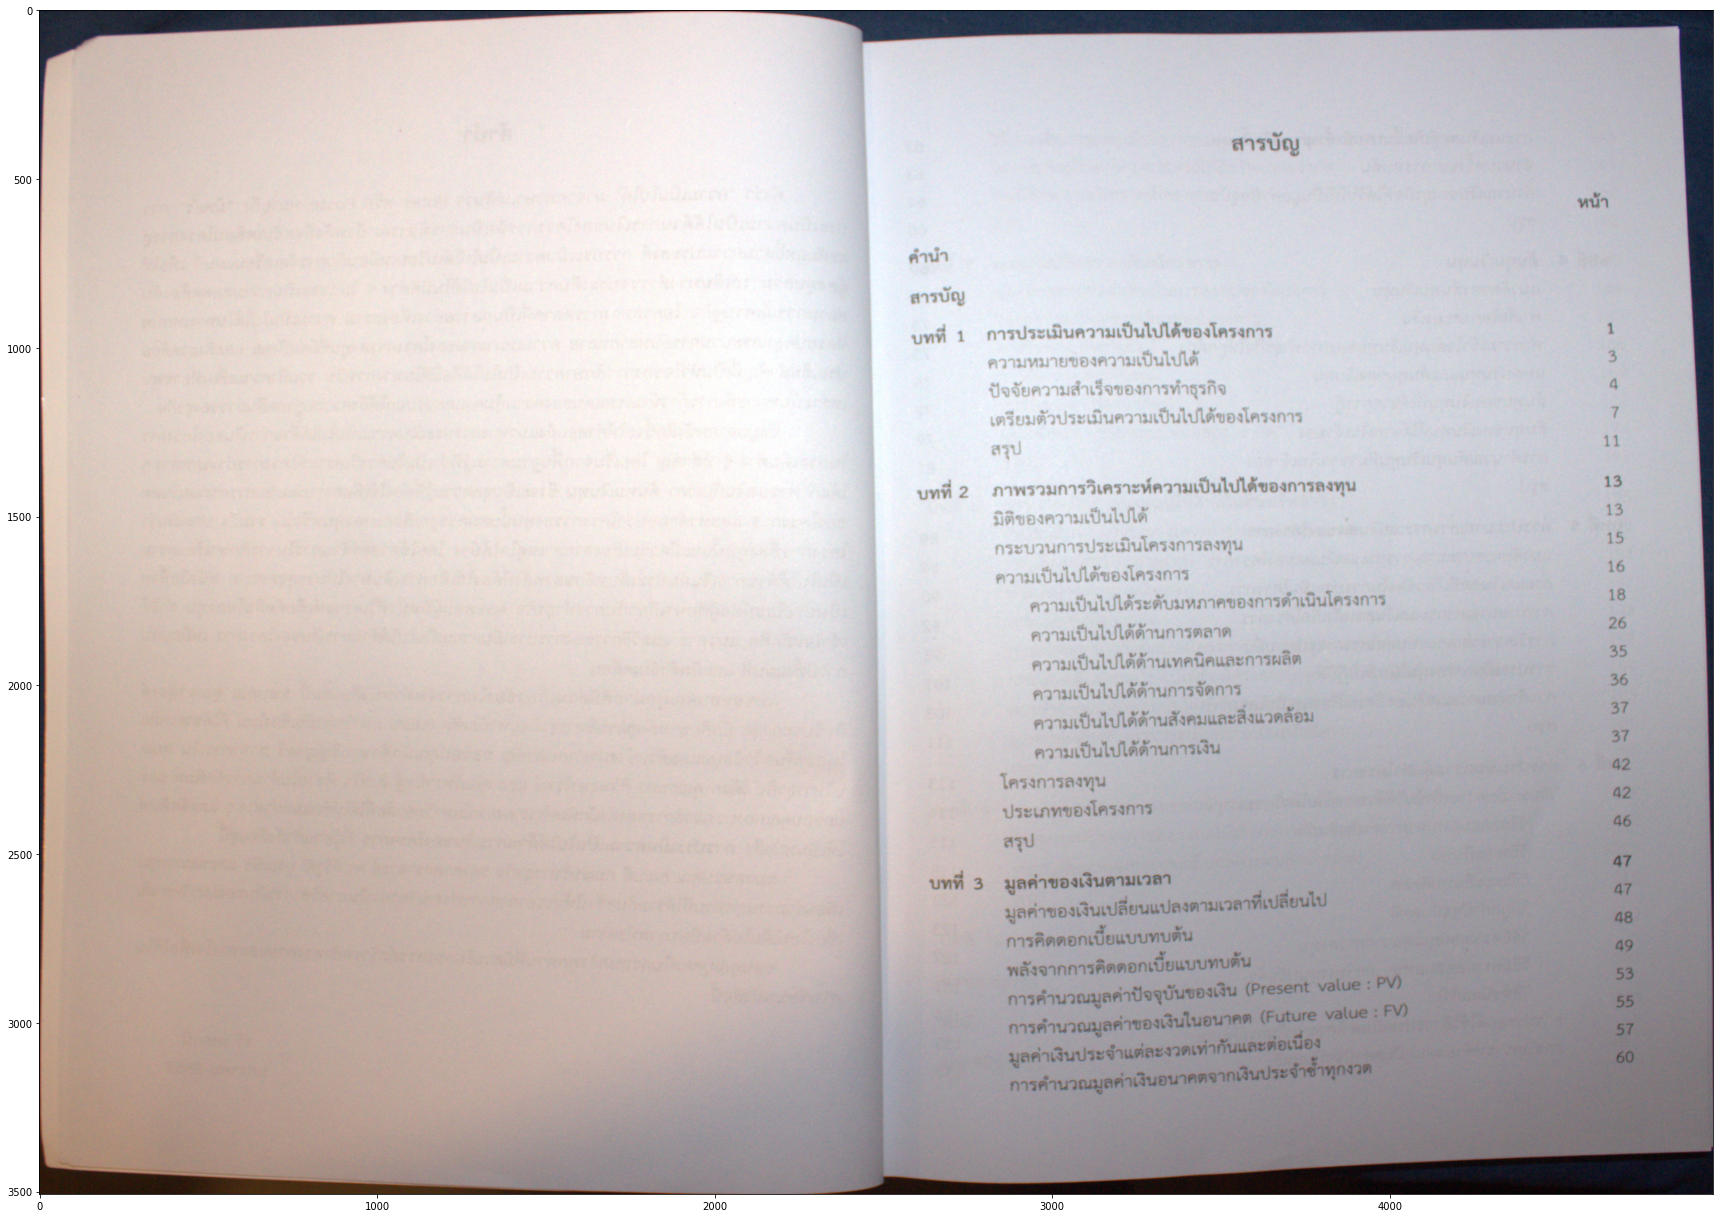

In [ ]:
dst = np.array([[0,0], [42, 0], [42, 29.7], [0, 29.7]]) * 300/2.54
matrix = cv2.getPerspectiveTransform(np.float32(box), np.float32(dst))
plot_image(cv2.warpPerspective(raw, matrix, tuple(np.int0(np.array([42, 29.7]) * 300 / 2.54))))

## Let's do it

In [106]:
from tqdm import tqdm
paths = glob("./Edit slot/*.CR2")
closed_arclength = lambda x: cv2.arcLength(x, closed = True)
for index in tqdm(range(len(paths))):
    raw = rawpy.imread(paths[index]).postprocess()
    if raw.shape[0] >= raw.shape[1]: raw = cv2.rotate(raw, cv2.ROTATE_90_COUNTERCLOCKWISE)
    blue = raw[:,:,0]
    blur = cv2.threshold(cv2.GaussianBlur(blue, (5,5), 0), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    canny = cv2.Canny(blur[1], 20, 200)
    canny = cv2.erode(cv2.dilate(canny, np.ones((5,5))), np.ones((5,5)))
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    ctr = max(contours, key = closed_arclength)
    rect = cv2.minAreaRect(ctr)
    box = cv2.boxPoints(rect)
    nearest = min(box, key = np.linalg.norm)
    tmp = []
    tmp_forward = []
    found = False
    for box_run in box:
        if list(box_run) == list(nearest):
            found = True
            tmp_forward.append(box_run)
        elif found:
            tmp_forward.append(box_run)
        else:
            tmp.append(box_run)
    box = np.int0(np.array(tmp_forward + tmp))
    width = 38 #21 if (index == 0) or (index == len(paths) - 1) else 38
    height = 29.7
    dpi = 300
    dst = np.array([[0,0], [width, 0], [width, height], [0, height]]) * dpi/2.54
    matrix = cv2.getPerspectiveTransform(np.float32(box), np.float32(dst))
    final = cv2.warpPerspective(raw, matrix, tuple(np.int0(np.array([width, height]) * dpi / 2.54)))
    final = cv2.cvtColor(final, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    final = clahe.apply(final)
    final = cv2.threshold(cv2.GaussianBlur(final, (5,5), 0), 70, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    cv2.imwrite("./processed/" + paths[index].split("\\")[-1][:-4] + ".png", np.int0(final[1]))

100%|██████████| 22/22 [00:47<00:00,  2.18s/it]


In [117]:
from PIL import Image

images = []
arrangement = [
    f"IMG_{i}.png" for i in [3545, 3698, 3699]
    + [j for j in range(3550, 3597)]
    + [j for j in range(3700,3712)]
    + [j for j in range(3624, 3686)]
    + [j for j in range(3713,3721)]]
for f in range(len(arrangement)):
    try:
        width = 21 if (f == 0) else 38
        height = 29.7
        dpi = 100
        size = np.int0(np.array([width, height]) * dpi / 2.54)
        image = Image.open("./processed/" + arrangement[f])
        image = image.resize(size, Image.ANTIALIAS)
        images.append(image)
    except:
        continue

pdf_path = "./feasibility_analysis.pdf"
    
images[0].save(
    pdf_path, "PDF" ,resolution=100, save_all=True, append_images=images[1:]
)